In [91]:
from collections import Counter
from lib.utils import read_file_to_object
from transformers import AutoTokenizer
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sbs

In [150]:
def get_statistics_from_raw(dataset: str):
    raw_train_source_df = pd.read_csv(f'../data/raw/{dataset}/train.source')
    raw_train_target_df = pd.read_csv(f'../data/raw/{dataset}/train.target')

    raw_test_source_df = pd.read_csv(f'../data/raw/{dataset}/test.source')
    raw_test_target_df = pd.read_csv(f'../data/raw/{dataset}/test.target')

    raw_validation_source_df = pd.read_csv(f'../data/raw/{dataset}/validation.source')
    raw_validation_target_df = pd.read_csv(f'../data/raw/{dataset}/validation.target')

    raw_source_df = pd.concat([raw_train_source_df, raw_test_source_df, raw_validation_source_df], axis=0)
    raw_target_df = pd.concat([raw_train_target_df, raw_test_target_df, raw_validation_target_df], axis=0)

    raw_data = pd.concat([raw_source_df, raw_target_df], axis=1)

    document_vocabulary = Counter()
    summary_vocabulary = Counter()

    document_lengths = []
    summary_lengths = []

    for _, row in tqdm(raw_data.iterrows(), total=len(raw_data.index)):
        summary = row['summary']
        text = row['text']

        if isinstance(summary, str) and isinstance(text, str):
            summary_tokens = summary.split(' ')
            text_tokens = text.split(' ')

            summary_lengths.append(len(summary_tokens))
            document_lengths.append(len(text_tokens))

            document_vocabulary.update(text_tokens)
            summary_vocabulary.update(summary_tokens)

    return document_lengths, summary_lengths, document_vocabulary, document_lengths, raw_data

def create_length_plot(counts, label: str, title: str, axs):
    counts = np.array(counts)
    counts = counts[counts < np.quantile(counts, 0.95)]

    ax = sbs.histplot(counts, bins=20, ax=axs)
    ax.set(xlabel = label, ylabel = 'token count')
    ax.set_title(title)

    if np.quantile(counts, 0.95) > 256:
        ax.axvline(256, 0, max(statistics[0]))
    if np.quantile(counts, 0.95) > 512:
        ax.axvline(512, 0, max(statistics[0]))
    if np.quantile(counts, 0.95) > 768:
        ax.axvline(768, 0, max(statistics[0]))

    return ax

def get_statistics_from_prepared(dataset: str, mdl: str):
    tokenenizer = AutoTokenizer.from_pretrained(mdl)


    prepared_source = f'../data/prepared/{dataset}/{mdl}/train.prepared.source.pkl'
    prepared_source = read_file_to_object(prepared_source)

    prepared_target = f'../data/prepared/{dataset}/{mdl}/train.prepared.target.pkl'
    prepared_target = read_file_to_object(prepared_target)

    source_unk_tokens = []
    target_unk_tokens = []

    for source in tqdm(prepared_source):
        ids = source.token_ids
        unknown_tokens = (ids == tokenenizer.unk_token_id).sum().item()
        length = (ids > 0).sum().item()

        source_unk_tokens.append(unknown_tokens / length if length > 0 else 0)

    for source in tqdm(prepared_target):
        ids = source.token_ids
        unknown_tokens = (ids == tokenenizer.unk_token_id).sum().item()
        length = (ids > 0).sum().item()

        target_unk_tokens .append(unknown_tokens / length if length > 0 else 0)

    return source_unk_tokens, target_unk_tokens

def get_dataset_statistics(dataset: str, mdl: str):
    statistics = get_statistics_from_raw(dataset)
    unknown_tokens = get_statistics_from_prepared(dataset, mdl)
    unknown_tokens_source = np.median(unknown_tokens[0])
    unknown_tokens_target = np.median(unknown_tokens[1])

    return {
        'statistics': statistics,
        'unknown_source': unknown_tokens_source,
        'unknown_target': unknown_tokens_target
    }

In [74]:
statistics = get_statistics_from_raw('mlsum')

100%|██████████| 242982/242982 [00:46<00:00, 5234.42it/s]


<AxesSubplot:xlabel='input document lengths', ylabel='token count'>

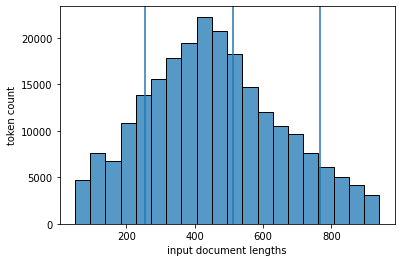

In [79]:
plot = create_length_plot(statistics[0], 'input document lengths')
plot.figure.savefig('../data/plots/test.png')
plot

<AxesSubplot:xlabel='summary document lengths', ylabel='token count'>

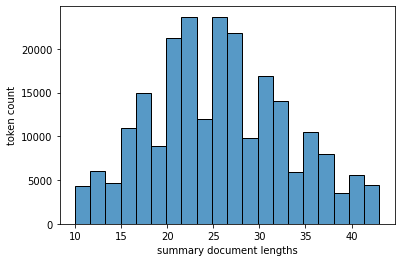

In [113]:
create_length_plot(statistics[1], 'summary document lengths')

In [116]:
cnn = get_dataset_statistics('cnn_dailymail', 'bert-base-uncased')


100%|██████████| 287113/287113 [00:04<00:00, 68523.54it/s]


In [117]:
mlsum = get_dataset_statistics('mlsum', 'bert-base-german-dbmdz-uncased')

100%|██████████| 220887/220887 [00:03<00:00, 67721.43it/s]


In [118]:
swisstext = get_dataset_statistics('swisstext', 'bert-base-german-dbmdz-uncased')

100%|██████████| 81000/81000 [00:01<00:00, 64289.73it/s]


In [121]:
spon_ard = get_dataset_statistics('spon_ard', 'bert-base-german-dbmdz-uncased')

100%|██████████| 6048/6048 [00:00<00:00, 63023.66it/s]


In [123]:
samples = [len(cnn['statistics'][0]), len(mlsum['statistics'][0]), len(swisstext['statistics'][0]), len(spon_ard['statistics'][0])]
samples

[311971, 242982, 100000, 7466]

In [162]:
unknowns = [cnn['unknown_source'], mlsum['unknown_source'], swisstext['unknown_source'], spon_ard['unknown_source']]

In [174]:
vocabs = [len(cnn['statistics'][2]), len(mlsum['statistics'][2]), len(swisstext['statistics'][2]), len(spon_ard['statistics'][2])]
vocabs

[2272019, 2838418, 2514329, 170840]

In [132]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,8))


<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

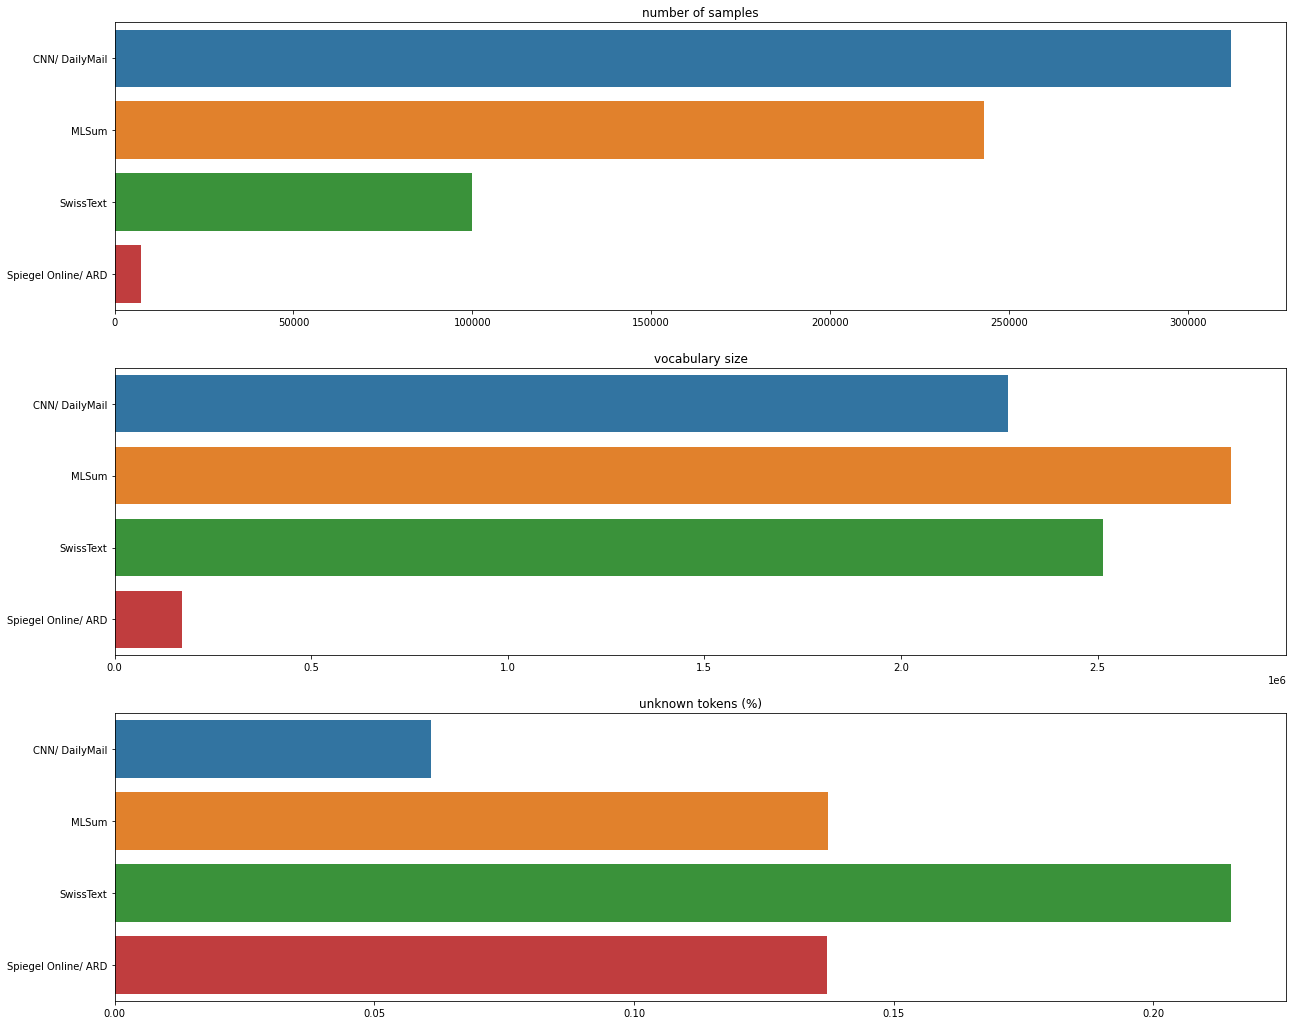

In [175]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(21,26))
labels = ['CNN/ DailyMail', 'MLSum', 'SwissText', 'Spiegel Online/ ARD']

plot = sbs.barplot(x=samples, y=labels, ax=axs[0])
plot.figure.set_figwidth(21)
plot.figure.set_figheight(18)
plot.set_title('number of samples')

plot = sbs.barplot(x=vocabs, y=labels, ax=axs[1])
plot.set_title('vocabulary size')

plot = sbs.barplot(x=unknowns, y=labels, ax=axs[2])
plot.set_title('unknown tokens (%)')

fig.savefig('../data/plots/datasets_comparison.png')

<AxesSubplot:xlabel='input document lengths', ylabel='token count'>

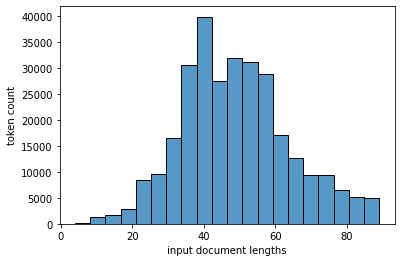

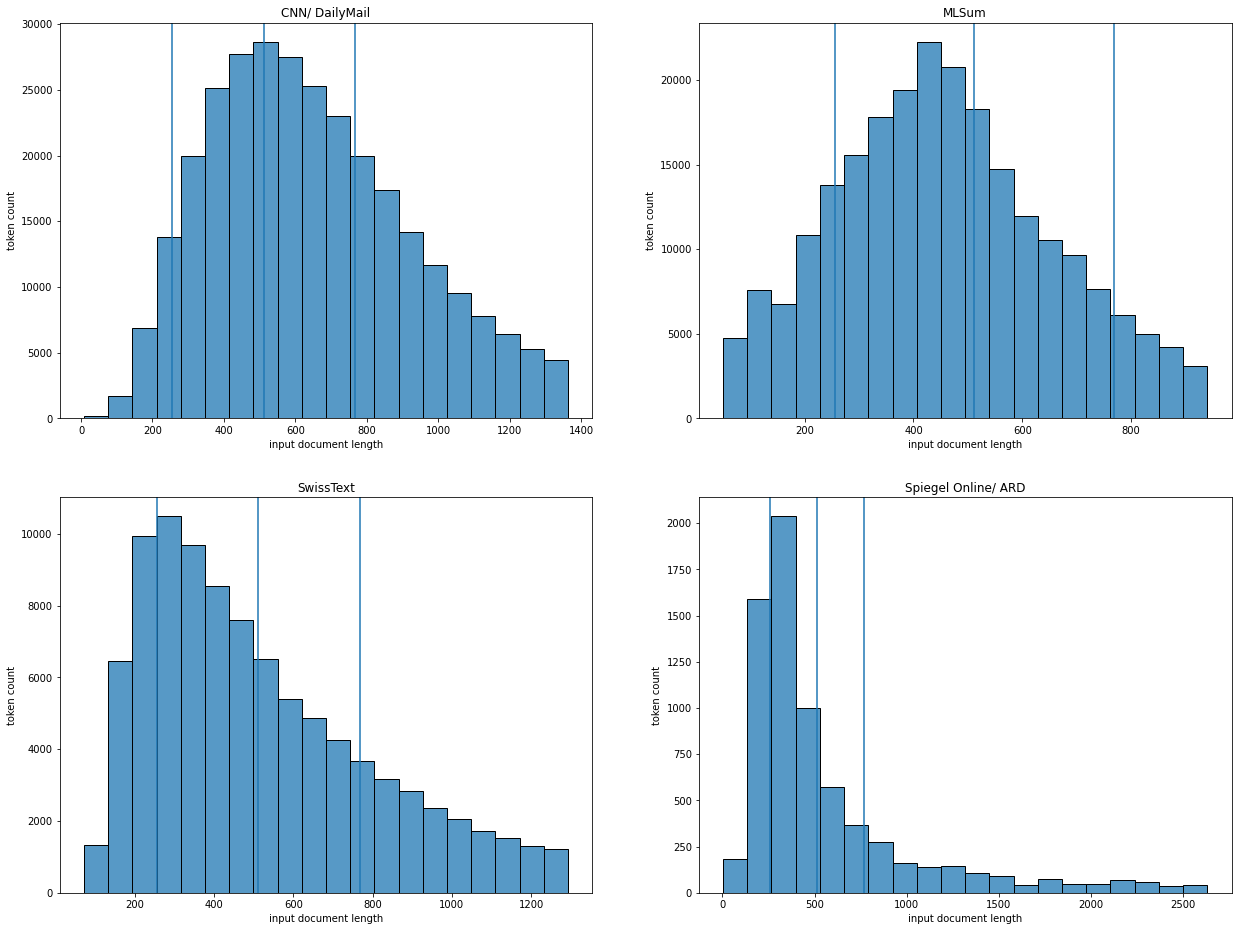

In [172]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(21,16))
create_length_plot(cnn['statistics'][0], 'input document length', 'CNN/ DailyMail', axs[0][0])
create_length_plot(mlsum['statistics'][0], 'input document length', 'MLSum', axs[0][1])
create_length_plot(swisstext['statistics'][0], 'input document length', 'SwissText', axs[1][0])
create_length_plot(spon_ard['statistics'][0], 'input document length', 'Spiegel Online/ ARD', axs[1][1])

fig.savefig('../data/plots/datasets_input_length.png')

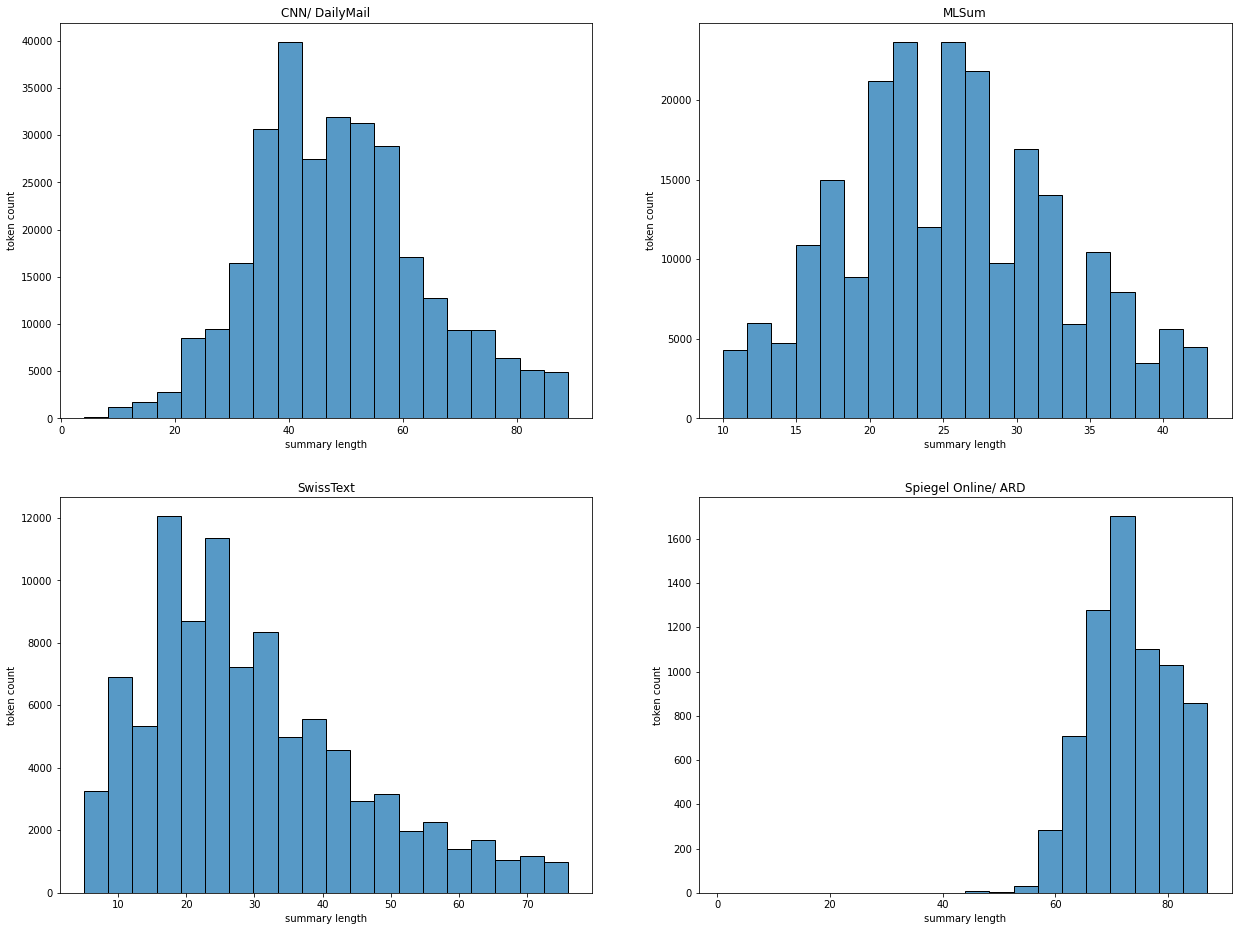

In [173]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(21,16))
create_length_plot(cnn['statistics'][1], 'summary length', 'CNN/ DailyMail', axs[0][0])
create_length_plot(mlsum['statistics'][1], 'summary length', 'MLSum', axs[0][1])
create_length_plot(swisstext['statistics'][1], 'summary length', 'SwissText', axs[1][0])
create_length_plot(spon_ard['statistics'][1], 'summary length', 'Spiegel Online/ ARD', axs[1][1])

fig.savefig('../data/plots/datasets_summary_length.png')